# **Intro**
In this notebook I set up conditional semi-supervised VAE that attempts to predict the proportions of MNIST numbers that have been superimposed on top of one another.

This is similar to the DIVA, where we use the rotation as labels and instead of having partially labeled numbers, we will have partially labeled number proportions. 
In that setup some labels are ommited to make it semi-supervised, which we will also do.
This will mimic the idea that we have bulk case vs. control examples (we don't know the proportions) and  simulate bulk samples from single-cell profiles, (where we don't have treatment data).
Using both of these sources of data we hope that we can work in OOD stuff.
Also, we use the M1+M2 formulation of semi-supervised as described here: "Semi-supervised Learning with Deep Generative Models", https://arxiv.org/abs/1406.5298

The difference in this model are the following: 


1.   We are learning proportions of numbers in an image, not a specific number.
This means that this is regression, not classification.
2.   We put the constraint directly on mu, not on an external classifier.
This is because we want to be able to augment mu and reconstruct in a logical manner.
For example, we want to be able to simulate the mixture of specific cell types by augmenting mu.
3.   We add in an additional classification loss for classification of treated vs. untreated.
We hope that by learning two separate processes (stack proportions and case/control classification) we will have enough information to compose them and handle out-of-distribution responses.
This did not work when we simply used the treatment as a condition, instead we will need to have a downstream classifier, linked to z, that will predict treatment status.



A lot of the model code was taken from this tutorial: https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb

And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/




# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [2]:
import os, sys

NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')

In [3]:
# prelude: set up git, etc.
%cd {NB_ROOT_PATH}
!( source setup.sh )

/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood
Ensuring ssh keys exist...
Copied key(s) to /root/.ssh/
total 12
-rw-r--r-- 1 root root  43 Aug 13 03:50 config
-rw------- 1 root root 432 Aug 13 03:50 id_rsa
-rw-r--r-- 1 root root 113 Aug 13 03:50 id_rsa.pub


In [129]:
%%bash
# do your git operations here

git status

[main 51baa8c] first pass on semi supervised stacked, and also adjustment of fully supervised DIVA where we add a few of the OOD samples
 3 files changed, 3 insertions(+), 1 deletion(-)
 rewrite experiments/DIVA_stacked_mnist.ipynb (90%)
 create mode 100644 experiments/ssDIVA_stacked_mnist.ipynb
 create mode 100644 experiments/stepwise_stacked_mnist.ipynb
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


To github.com:nrosed/sc_bulk_ood.git
   fb4782a..51baa8c  main -> main


# **Imports**

In [32]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from sklearn.manifold import TSNE

# programming stuff
import time
import os
import pickle
from pathlib import Path

# Load the TensorBoard notebook extension
%load_ext tensorboard

# load methods from other files
from mnist_preprocessing import generate_data as gd

# I disable eager execution ... forgot why
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

warnings.filterwarnings('ignore')
%pylab inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Populating the interactive namespace from numpy and matplotlib


# **Load / Pre-process data**
Import + reshape the non-rotated MNIST data

In [6]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(X_train.shape)
print(X_test.shape)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

print(Y_train)

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 ... 5 6 8]


Import + reshape and rotate MNIST data.
In our single-cell analogy, rotation is a treatment and the number value is a cell-type.

In [7]:
(X_train_r, Y_train_r), (X_test_r, Y_test_r) = mnist.load_data()

# now add in the rotation
def rotate_90(img):
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

# rotate the training data
X_train_r = np.array([rotate_90(xi) for xi in X_train_r])
Y_train_r = Y_train

# rotate the test data
X_test_r = np.array([rotate_90(xi) for xi in X_test_r])
Y_test_r = Y_test

# reshape the data
X_train_r = X_train_r.astype('float32') / 255.
X_test_r = X_test_r.astype('float32') / 255.

n_pixels = np.prod(X_train_r.shape[1:])
X_train_r = X_train_r.reshape((len(X_train_r), n_pixels))
X_test_r = X_test_r.reshape((len(X_test_r), n_pixels))

print(X_train_r.shape)
print(X_test_r.shape)
print(Y_train_r)

(60000, 784)
(10000, 784)
[5 0 4 ... 5 6 8]


Demo the data, to make sure everything works

Proportion of each MNIST number to be superimposed: [ 6  6 23  1  5 12  5 35  1  6]
10 stacked 5's


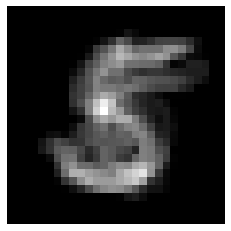

Rotated 10 stacked 5's


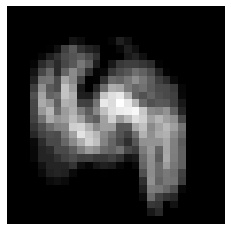

100 stacked 5's


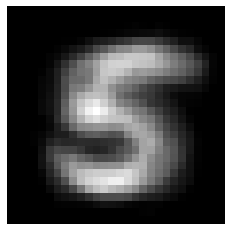

50 random 0's and 50 random 1's


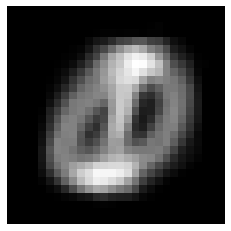

Rotated 50 random 0's and 50 random 1's


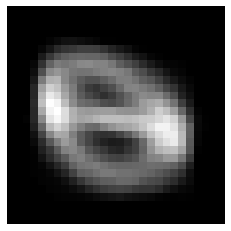

Random Stack


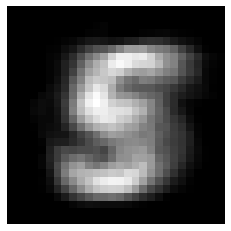

Proportion of each MNIST number: [ 0  3  0  0  0 74  1  2 20  0]
Rotated Random Stack


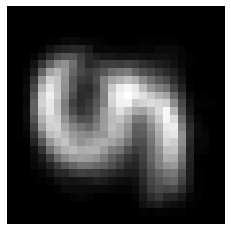

Proportion of each rotated MNIST number: [ 6  1  0  3  0 82  5  0  1  2]


In [8]:
# show how each method works and give some sample output
prop_vec = gd.gen_prop_vec_lognormal()
print(f"Proportion of each MNIST number to be superimposed: {prop_vec}")

# print 10 random 5's
print("10 stacked 5's")
single_num = gd.gen_single_num_sum(10, 5, X_train, Y_train)
plt.imshow(single_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

# print 10 random 5's
print("Rotated 10 stacked 5's")
single_num = gd.gen_single_num_sum(10, 5, X_train_r, Y_train_r)
plt.imshow(single_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

# print 100 random 5's
print("100 stacked 5's")
single_num = gd.gen_single_num_sum(100, 5, X_train, Y_train)
plt.imshow(single_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

# print 50 random 0's and 50 random 1's
print("50 random 0's and 50 random 1's")
zero_five_num = gd.gen_prop_num_sum([50, 50, 0, 0, 0, 0, 0, 0, 0, 0], X_train, Y_train)
plt.imshow(zero_five_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

print("Rotated 50 random 0's and 50 random 1's")
zero_five_num = gd.gen_prop_num_sum([50, 50, 0, 0, 0, 0, 0, 0, 0, 0], X_train_r, Y_train_r)
plt.imshow(zero_five_num.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

print("Random Stack")
y_stacked, x_stacked = gd.make_stacked_sample(X_train, Y_train)
plt.imshow(x_stacked.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print(f"Proportion of each MNIST number: {y_stacked}")


print("Rotated Random Stack")
y_stacked, x_stacked = gd.make_stacked_sample(X_train_r, Y_train_r)
plt.imshow(x_stacked.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print(f"Proportion of each rotated MNIST number: {y_stacked}")


Now generate all the new images

In [9]:
# in a loop randomly generate images and save the X and Y
num_samples_train = 200000
num_samples_test = 20000

# make / load training data
training_data_path = "./data/stacked_train_lognorm.pkl"
X_stack_train, Y_stack_train =  gd.make_all_stacked_samples(X_train, Y_train, 
                                                         training_data_path, 
                                                         num_samples_train)

# make / load test data
testing_data_path = "./data/stacked_test_lognorm.pkl"
X_stack_test, Y_stack_test =  gd.make_all_stacked_samples(X_test, Y_test, 
                                                         testing_data_path, 
                                                         num_samples_test)


##################################################
#####. Rotated MNIST
##################################################

# make / load training data
training_r_data_path = "./data/stacked_rotated_train_lognorm.pkl"
X_stack_train_r, Y_stack_train_r =  gd.make_all_stacked_samples(X_train_r, 
                                                         Y_train_r, 
                                                         training_r_data_path, 
                                                         num_samples_train)


# make / load test data
testing_r_data_path = "./data/stacked_rotated_test_lognorm.pkl"
X_stack_test_r, Y_stack_test_r =  gd.make_all_stacked_samples(X_test_r, 
                                                         Y_test_r, 
                                                         testing_r_data_path, 
                                                         num_samples_test)


##################################################
#####. Put it all together
##################################################


X_full_train = np.concatenate([X_stack_train, X_stack_train_r])
Y_full_train = np.concatenate([Y_stack_train, Y_stack_train_r])

X_full_test = np.concatenate([X_stack_test, X_stack_test_r])
Y_full_test = np.concatenate([Y_stack_test, Y_stack_test_r])

print(X_full_test.shape)
print(X_full_train.shape)

### also create the condition label (regular=0, rotated=1) 

Label_train = np.concatenate([np.zeros(Y_stack_train.shape[0]), np.ones(Y_stack_train_r.shape[0])])
Label_test = np.concatenate([np.zeros(Y_stack_test.shape[0]), np.ones(Y_stack_test_r.shape[0])])
label_train = to_categorical(Label_train)
label_test = to_categorical(Label_test)


(40000, 784)
(400000, 784)


# **Model Definition**


## Hyperparameters

In [10]:
batch_size = 500
n_epoch = 5

beta_kl_slack = 10
beta_kl_rot = 10
beta_kl_prop = 10

# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = 10 # latent space size, one latent dimension PER MNIST digit
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of encoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer

activ = 'relu'
optim = Adam(learning_rate=0.001)

n_x = X_full_train.shape[1]
n_y = Y_full_train.shape[1]
n_label = label_train.shape[1]

print(f"length of X {n_x} and length of y {n_y} and n_label {n_label}")



length of X 784 and length of y 10 and n_label 2


## Encoder

In [11]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
props = Input(shape=(n_y,))

# concatenate input with the label 
inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_h = Dense(encoder_dim, activation=activ, name="encoder_1")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_prop = Dense(n_z, activation='linear', name = "mu_prop")(encoder_h)
l_sigma_prop = Dense(n_z, activation='linear', name = "sigma_prop")(encoder_h)


## Latent Space

In [12]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_prop = Lambda(sample_z, output_shape = (n_z, ), name="z_samp_prop")([mu_prop, l_sigma_prop, n_z])


## Decoder + Classifiers

In [13]:
def null_f(args):
    return args

# set up decoder network
# this is a decoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

# this is the proportions we try to estimate
decoder_props = ReLU(name = "mu_prop_pred") 

# we use this to get sigma to do sampling later
decoder_sigma = Lambda(null_f, name = "l_sigma_prop_pred")

# link them together
h_p = decoder_hidden(z_prop)
outputs = decoder_out(h_p)


prop_outputs = decoder_props(mu_prop)
sigma_outputs = decoder_sigma(l_sigma_prop)


d_in = Input(shape=(n_z,))
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)




## Loss

In [14]:

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl_prop = beta_kl_prop * K.sum(K.exp(l_sigma_prop) + K.square(mu_prop) - 1. - l_sigma_prop, axis=-1)
    return recon + kl_prop 

def KL_loss(y_true, y_pred):
	return(beta_kl * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

prop_loss_scale = 100
def prop_loss(y_true, y_pred):
	return K.sum((y_true -  y_pred)**2, axis=-1) * prop_loss_scale

def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    return recon



## Make the computational graph

In [39]:

known_prop_vae = Model(X, [outputs, prop_outputs, sigma_outputs])
unknown_prop_vae = Model(X, outputs)

known_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, None]) #, metrics = [KL_loss, recon_loss])
unknown_prop_vae.compile(optimizer=optim, loss=vae_loss) #, metrics = [KL_loss, recon_loss])


encoder = Model(X, mu_prop)

decoder = Model(d_in, d_out)

print(known_prop_vae.summary())
print(unknown_prop_vae.summary())


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder_1 (Dense)               (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
sigma_prop (Dense)              (None, 10)           5130        encoder_1[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_z_samp_prop/truediv [(None, 10)]         0           sigma_prop[0][0]                 
____________________________________________________________________________________________

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [16]:
from tqdm import tnrange, tqdm_notebook
def fit_model(X_unknown_prop, X_known_prop, Y_known_prop, epochs):
    assert len(X_known_prop) % len(X_unknown_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    
    for epoch in tnrange(epochs):
        labeled_index = np.arange(len(X_known_prop))
        np.random.shuffle(labeled_index)
        
        # Repeat the unlabeled data to match length of labeled data
        unlabeled_index = []
        for i in range(len(X_known_prop) // len(X_unknown_prop)):
            l = np.arange(len(X_unknown_prop))
            np.random.shuffle(l)
            unlabeled_index.append(l)
        unlabeled_index = np.concatenate(unlabeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        with tnrange(batches, leave=False) as pbar:
            for i in range(batches):
                # Labeled
                index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
                loss = known_prop_vae.train_on_batch(X_known_prop[index_range], 
                                                      [X_known_prop[index_range], Y_known_prop[index_range]])
                
                # Unlabeled
                index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
                loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range], 
                                                         X_unknown_prop[index_range])]


                pbar.desc = 'Loss: %s' % loss
                history.append(loss)
                
                pbar.update(1)
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history

# **Experiments**

Now lets train and evaluate the model.
First we train with only some proportions of rotated 3's..
We will then decrease the proportion of rotated 3's in samples from 0.5 to 0.

In [17]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))


Setup the data so that we remove all the examples with a high proportion of rotated 3's

In [88]:
# ok now we will attempt OOD
# remove rotated 3s

unrot_idx = range(0, 200000)
rot_idx = range(200000, 400000)

X_train_unrot = X_full_train[unrot_idx,:]
Y_train_unrot = Y_full_train[unrot_idx,:]
label_train_unrot = label_train[unrot_idx,:]


X_train_rot = X_full_train[rot_idx,:]
Y_train_rot = Y_full_train[rot_idx,:]
label_train_rot = label_train[rot_idx,:]


# split the unrotated into two sets, for known and unknown proportions
sss = StratifiedShuffleSplit(n_splits=2, test_size=100000, random_state=0)
_, index = sss.split(X_train_unrot, label_train_unrot)
X_kp_unrot, label_kp_unrot, y_kp_unrot = X_train_unrot[index[1]], label_train_unrot[index[1]], Y_train_unrot[index[1]]
X_unkp_unrot, label_unkp_unrot, y_unkp_unrot = X_train_unrot[index[0]], label_train_unrot[index[0]], Y_train_unrot[index[0]]


# now split the rotated into two sets, for known and unknown proportions
sss = StratifiedShuffleSplit(n_splits=2, test_size=100000, random_state=0)
_, index = sss.split(X_train_rot, label_train_rot)
X_kp_rot, label_kp_rot, y_kp_rot = X_train_rot[index[1]], label_train_rot[index[1]], Y_train_rot[index[1]]
X_unkp_rot, label_unkp_rot, y_unkp_rot = X_train_rot[index[0]], label_train_rot[index[0]], Y_train_rot[index[0]]

# now filter out specific frequencies of a number that are rotated
keep_rot_idx = y_kp_rot[:,1] < 0.1
X_kp_rot = X_kp_rot[keep_rot_idx, :]
label_kp_rot = label_kp_rot[keep_rot_idx, :]
y_kp_rot = y_kp_rot[keep_rot_idx, :]

# for unknown proportions put together the rotated and unrotated
X_unkp = np.concatenate((X_unkp_unrot, X_unkp_rot))
label_unkp = np.concatenate((label_unkp_unrot, label_unkp_rot))
y_unkp = np.concatenate((y_unkp_unrot, y_unkp_rot))

# the same for for known proportions put together the rotated and unrotated
X_kp = X_kp_unrot #np.concatenate((X_kp_unrot, X_kp_rot))
label_kp = label_kp_unrot #np.concatenate((label_kp_unrot, label_kp_rot))
y_kp = y_kp_unrot #np.concatenate((y_kp_unrot, y_kp_rot))


# now take a subsample of the full dataset
unkp_size = 50000
kp_size = 50000
unkp_rand_idx = np.random.choice(X_unkp.shape[0], size=unkp_size, replace=False)
kp_rand_idx = np.random.choice(X_kp.shape[0], size=kp_size, replace=False)



Now train

In [89]:
history = fit_model(X_unkp[unkp_rand_idx,:],
                    X_kp[kp_rand_idx,:], 
                    y_kp[kp_rand_idx,:], epochs=10)

print(X_full_test[0].shape) 
print(Y_full_test[0].shape)


output_mu_prop = encoder.predict(X_full_test, batch_size=batch_size)
test_error = [mean_abs_error(output_mu_prop[idx], Y_full_test[idx]) 
                  for idx in range(0, X_full_test.shape[1])]

print(f"mean test_error: {np.round(np.mean(test_error), decimals=3)}\n"
      f"median test_error: {np.round(np.median(test_error), decimals=3)}\n"
      f"max test_error: {np.round(np.max(test_error), decimals=3)}")





Elapsed:  128.576340675354
(784,)
(10,)
mean test_error: 0.023
median test_error: 0.022
max test_error: 0.05


# **Make Z to Z' function**

## Define model

In [118]:
z_in = Input(shape=(n_z,))

# set up network
expand_h1 = Dense(10, activation=activ, name="expand1")(z_in)
expand_h2 = Dense(20, activation=activ, name="expand2")(expand_h1)
expand_h3 = Dense(10, activation=activ, name="expand3")(expand_h2)
# final reconstruction
z_out = Dense(n_z, activation='sigmoid', name = "decoder_out")(expand_h3)



z_transform = Model(z_in, z_out)
z_transform.compile(optimizer=optim, loss=prop_loss) 

print(z_transform.summary())



Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
expand1 (Dense)              (None, 10)                110       
_________________________________________________________________
expand2 (Dense)              (None, 20)                220       
_________________________________________________________________
expand3 (Dense)              (None, 10)                210       
_________________________________________________________________
decoder_out (Dense)          (None, 10)                110       
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________
None


## **Fit**

In [119]:
# to fit we will use the paired Z to Z' for unknown proportions

unkp_size = 150000
train_unrot = np.concatenate((X_unkp_unrot, X_kp_unrot))
unkp_rand_idx = np.random.choice(train_unrot.shape[0], size=unkp_size, replace=False)
z_unrot = encoder.predict(train_unrot[unkp_rand_idx, :], batch_size=batch_size)


# rotate the training data
simulated_X_unkp_rot = np.array([rotate_90(xi.reshape(28, 28)) for xi in train_unrot])
simulated_X_unkp_rot = simulated_X_unkp_rot.reshape((len(simulated_X_unkp_rot), n_pixels))
z_rot = encoder.predict(simulated_X_unkp_rot[unkp_rand_idx, :], batch_size=batch_size)



In [120]:


z_transform_hist = z_transform.fit(z_unrot, z_rot, batch_size=batch_size*2, epochs=n_epoch*10)



Train on 150000 samples
Epoch 1/50
150000/150000 [==============================] - 1s 7us/sample - loss: 75.8883
Epoch 2/50
150000/150000 [==============================] - 1s 3us/sample - loss: 19.8699
Epoch 3/50
150000/150000 [==============================] - 1s 3us/sample - loss: 19.7826
Epoch 4/50
150000/150000 [==============================] - 1s 3us/sample - loss: 19.7535
Epoch 5/50
150000/150000 [==============================] - 1s 4us/sample - loss: 19.7394
Epoch 6/50
150000/150000 [==============================] - 1s 4us/sample - loss: 19.7313
Epoch 7/50
150000/150000 [==============================] - 1s 4us/sample - loss: 19.7261
Epoch 8/50
150000/150000 [==============================] - 1s 4us/sample - loss: 19.7226
Epoch 9/50
150000/150000 [==============================] - 1s 4us/sample - loss: 19.7201
Epoch 10/50
150000/150000 [==============================] - 1s 4us/sample - loss: 19.7182
Epoch 11/50
150000/150000 [==============================] - 1s 4us/sample 

In [121]:
z_pred_out = z_transform.predict(z_unrot, batch_size=batch_size)

test_error = [mean_abs_error(z_pred_out[idx], z_unrot[idx]) 
                  for idx in range(0, z_unrot.shape[1])]

print(f"mean test_error: {np.round(np.mean(test_error), decimals=3)}\n"
      f"median test_error: {np.round(np.median(test_error), decimals=3)}\n"
      f"max test_error: {np.round(np.max(test_error), decimals=3)}")


mean test_error: 0.09300000220537186
median test_error: 0.09399999678134918
max test_error: 0.09799999743700027


# **Inspect the output**

We will take two examples from our training and see how well it reconstructs.
We first look at the ground truth so we know what we should expect.

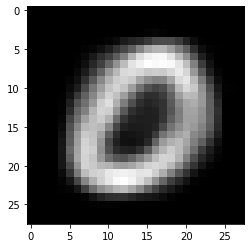

[0.88 0.   0.   0.03 0.01 0.04 0.   0.   0.03 0.01]
[1. 0.]


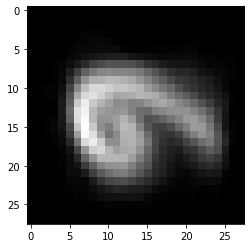

[0.01 0.01 0.01 0.07 0.   0.   0.88 0.   0.01 0.01]
[0. 1.]


In [94]:
plot_idx = 3 #20

plt.imshow(X_unkp_unrot[plot_idx].reshape(28, 28), cmap = plt.cm.gray)
plt.show()
print(y_unkp_unrot[plot_idx])
print(label_unkp_unrot[plot_idx])

plt.imshow(X_unkp_rot[plot_idx].reshape(28, 28), cmap = plt.cm.gray)
plt.show()
print(y_unkp_rot[plot_idx])
print(label_unkp_rot[plot_idx])


Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

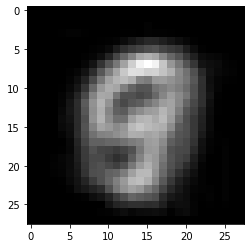

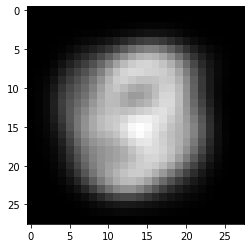

In [122]:
plot_idx = 5

X_input = train_unrot[unkp_rand_idx, :]
mu_prop = encoder.predict(X_input, batch_size=batch_size)
z_trans = z_transform.predict(mu_prop, batch_size=batch_size)
x_rot = decoder.predict(z_trans, batch_size=batch_size)

encoded_X0 = x_rot[plot_idx]

plt.imshow(X_input[plot_idx,:].reshape(28, 28), cmap = plt.cm.gray)
plt.show()

plt.imshow(encoded_X0.reshape(28, 28), cmap = plt.cm.gray)
plt.show()


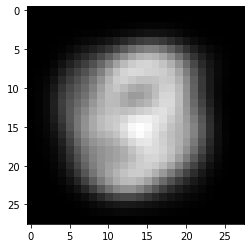

In [128]:
plot_idx = 0

mu_prop = np.ones(10)*0.01
mu_prop[plot_idx] = 10
mu_prop = mu_prop.reshape(1, n_z)
z_trans = z_transform.predict(mu_prop)
x_rot = decoder.predict(z_trans)

plt.imshow(x_rot.reshape(28, 28), cmap = plt.cm.gray)
plt.show()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...
[t-SNE] Computed neighbors for 5000 samples in 0.359s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.022726
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.562454
[t-SNE] KL divergence after 300 iterations: 1.567279
t-SNE done! Time elapsed: 13.71576189994812 seconds
(5000, 2)
(5000, 2)


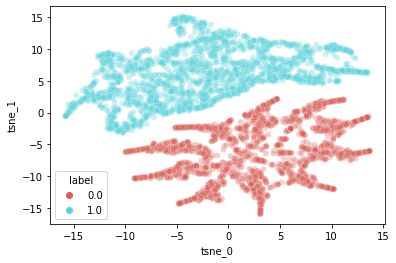

In [127]:
# plot proportions
mu_prop = encoder.predict(X_full_test, batch_size=batch_size)
encodings= np.asarray(mu_prop)
encodings = encodings.reshape(X_full_test.shape[0], n_z)
tsne_idx = np.random.choice(encodings.shape[0], size=5000, replace=False)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings[tsne_idx,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['label'] = Label_test[tsne_idx]

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)




In [71]:
print(X_full_test[0].shape) 
print(Y_full_test[0].shape)

def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

output_prop_test = encoder.predict(X_full_test, batch_size=batch_size)

test_error = [mean_abs_error(output_prop_test[idx], Y_full_test[idx]) 
                  for idx in range(0, X_full_test.shape[0])]

print(f"mean test_error: {np.round(np.mean(test_error), decimals=3)}\n"
      f"median test_error: {np.round(np.median(test_error), decimals=3)}\n"
      f"max test_error: {np.round(np.max(test_error), decimals=3)}")


output_prop = encoder.predict(X_full_train, batch_size=batch_size)
train_error = [mean_abs_error(output_prop[idx], Y_full_train[idx]) 
                  for idx in range(0, X_full_train.shape[0])]

print(f"mean train_error: {np.round(np.mean(train_error), decimals=3)}\n"
      f"median train_error: {np.round(np.median(train_error), decimals=3)}\n"
      f"max train_error: {np.round(np.max(train_error), decimals=3)}")


(784,)
(10,)
mean test_error: 0.034
median test_error: 0.034
max test_error: 0.071
mean train_error: 0.034
median train_error: 0.034
max train_error: 0.069


686
rotated 1


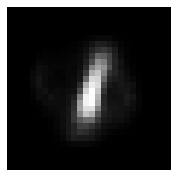

In [ ]:

def method_sample_z(args):
    mu, l_sigma = args
    eps = np.random.normal(size=(batch_size, n_z), loc=0., scale=1.)
    return mu + np.exp(l_sigma / 2) * eps

def sample_digit(digit, Y_test, digit_scale, rotate):
  digit_idx = np.where(Y_test == digit)

  label_vec = np.array([1., 0.]).reshape((1, 2))
  if rotate:
    label_vec = np.array([0., 1.]).reshape((1, 2))

  pred_input = X_full_test[digit_idx[0]]
  rand_idx = np.random.choice(pred_input.shape[0], size=batch_size, replace=False)
  pred_input = pred_input[rand_idx]

  test_X, test_mu, test_label, test_lsigma = cls_prop_vae.predict(pred_input, batch_size=batch_size)

  encoded_X0 = np.ones(10)*0.0001
  encoded_X0[digit] = digit_scale
  rand_lsigma = np.random.random_integers(low = 0, high = 249)
  z_0_digit = method_sample_z([encoded_X0, test_lsigma])
  z_0_digit = z_0_digit[rand_lsigma].reshape((1,10))
  return(z_0_digit)

digit_img = 1

keep_rot_idx = Y_full_test[:,digit_img] > 0.9
print(sum(keep_rot_idx))
X_example = X_full_test[keep_rot_idx,]
z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

z_0_digit = sample_digit(digit_img, Y_test, 10, rotate=True)
plt.figure(figsize=(3, 3))

# it is rotated
rotate_1hot = np.array([0., 10.])

# slack, prop, rot
slack_sample = z_slack[0]
slack_sample = [0,0,0,0,0,0,0,0,0,0]
pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

print(f"rotated {digit_img}")
plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

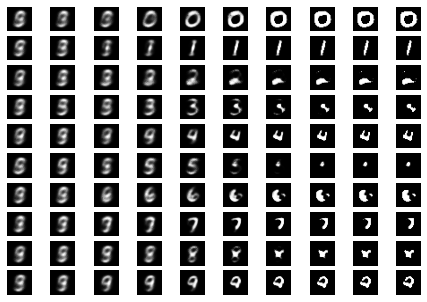

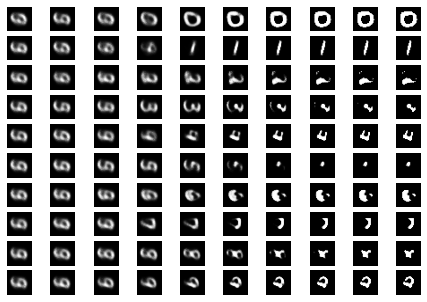

In [ ]:
img_it = 0
sides = 10
slack_sample = [0,0,0,0,0,0,0,0,0,0]
rotate_scale = 10


rotate_1hot = np.array([rotate_scale, 0.])
rotate_val = False
for i in range(0, sides):
    for j in range(0, sides):
        z_0_digit = sample_digit(i, Y_test, 2**j, rotate=rotate_val)

        digit_img = i

        keep_rot_idx = Y_full_test[:,digit_img] > 0.9
        X_example = X_full_test[keep_rot_idx,]
        z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

        # slack, prop, rot
        slack_sample = z_slack[0]
        pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

        decoded = decoder.predict(pred_input)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()


rotate_1hot = np.array([0., rotate_scale])
rotate_val = True
img_it = 0
sides = 10
for i in range(0, sides):
    for j in range(0, sides):
        z_0_digit = sample_digit(i, Y_test, 2**j, rotate=rotate_val)
        digit_img = i

        keep_rot_idx = Y_full_test[:,digit_img] > 0.9
        X_example = X_full_test[keep_rot_idx,]
        z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

        # slack, prop, rot
        slack_sample = z_slack[0]
        pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))

        decoded = decoder.predict(pred_input)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

In [ ]:
# predict rotated numbers

# normalizing the data to make the neural network easier to learn
x_train_r = normalize(X_train_r, axis=1)
x_test_r = normalize(X_test_r, axis=1)

#choosing the sequential model
classification_model = Sequential()

#defining the architecture of the model
X_class = Input(shape=(n_x,))
classification_model.add(X_class)
classification_model.add(Dense(512, activation='relu'))
classification_model.add(Dense(128, activation='relu'))
classification_model.add(Dense(10, activation='softmax'))

#defining the parameters to train the model
classification_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#training the model
classification_model.fit(x_train_r,Y_train_r,epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 19s 318us/sample - loss: 0.2604 - accuracy: 0.9231
Epoch 2/5
60000/60000 [==============================] - 20s 327us/sample - loss: 0.0984 - accuracy: 0.9704
Epoch 3/5
60000/60000 [==============================] - 23s 389us/sample - loss: 0.0639 - accuracy: 0.9801
Epoch 4/5
60000/60000 [==============================] - 20s 331us/sample - loss: 0.0452 - accuracy: 0.9857
Epoch 5/5
60000/60000 [==============================] - 20s 332us/sample - loss: 0.0334 - accuracy: 0.9888


In [ ]:

num_correct = 0
num_digits = 10
num_rep = 100
rotate_1hot = np.array([0., 10])
rotate_val = True
slack_sample = method_sample_z([0,1])[0]
acc = []
for digit_idx in range(0, num_digits):
  num_correct = 0
  for idx_rep in range(0, num_rep):
    z_0_digit = sample_digit(digit_idx, Y_test, 2**4, rotate=rotate_val)
    digit_img = digit_idx

    keep_rot_idx = Y_full_test[:,digit_img] > 0.9
    X_example = X_full_test[keep_rot_idx,]
    z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

    # slack, prop, rot
    slack_sample = z_slack[10]
    slack_sample = [0,0,0,0,0,0,0,0,0,0]
    pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))


    decoded = decoder.predict(pred_input)
    predictions = classification_model.predict(decoded)
    #print(f"true: {idx} pred: {np.argmax(predictions)}")
    if(digit_idx == np.argmax(predictions)):
      num_correct += 1
  acc = np.append(acc, num_correct)

print(np.mean(acc))
print(acc)

89.4
[100.   0. 100. 100. 100. 100. 100. 100.  94. 100.]


 pred: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2669696e-33 1.0000000e+00
  1.2394320e-37 0.0000000e+00 6.2989287e-19 0.0000000e+00 1.5549239e-20]]
rotated 1


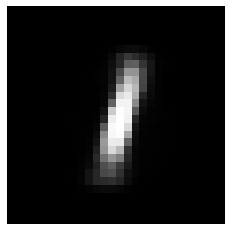

 pred: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.4296302e-34 1.0000000e+00
  2.2669416e-38 0.0000000e+00 8.0320490e-21 0.0000000e+00 1.0877010e-19]]
rotated 1


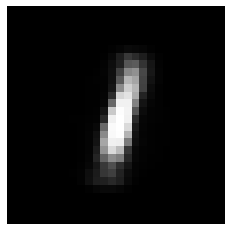

 pred: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 6.1041823e-32 1.0000000e+00
  1.6018180e-35 0.0000000e+00 1.8494179e-17 0.0000000e+00 1.8535974e-19]]
rotated 1


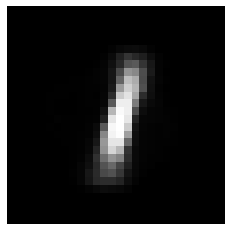

 pred: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 7.1135345e-35 1.0000000e+00
  9.3835317e-38 0.0000000e+00 2.9778233e-18 0.0000000e+00 1.2294643e-20]]
rotated 1


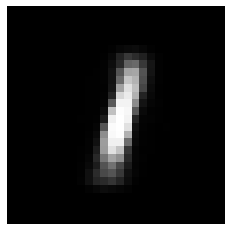

 pred: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 7.3807827e-35 1.0000000e+00
  2.1847085e-38 0.0000000e+00 8.1635825e-20 0.0000000e+00 2.0035867e-22]]
rotated 1


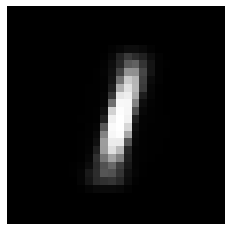

 pred: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 3.9592520e-33 1.0000000e+00
  4.5715831e-37 0.0000000e+00 2.7233218e-18 0.0000000e+00 9.0542046e-20]]
rotated 1


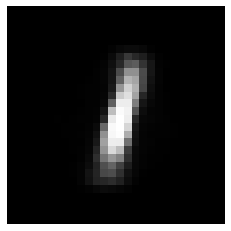

 pred: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.4781282e-32 1.0000000e+00
  1.1746939e-36 0.0000000e+00 1.9257983e-18 0.0000000e+00 8.4014150e-20]]
rotated 1


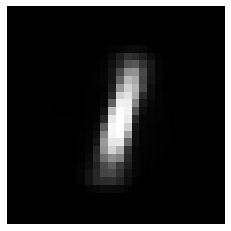

 pred: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 5.6530504e-33 1.0000000e+00
  1.7596270e-37 0.0000000e+00 3.8519565e-19 0.0000000e+00 2.2488058e-20]]
rotated 1


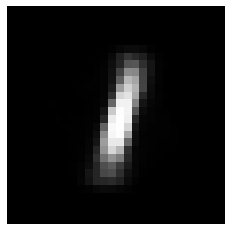

 pred: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 3.1859633e-33 1.0000000e+00
  1.2958946e-37 0.0000000e+00 4.4244852e-19 0.0000000e+00 3.6945802e-20]]
rotated 1


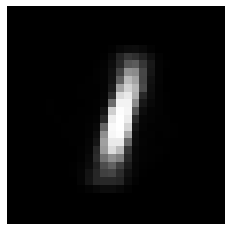

 pred: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2369366e-32 1.0000000e+00
  4.6423198e-36 0.0000000e+00 1.9996061e-17 0.0000000e+00 1.7152327e-19]]
rotated 1


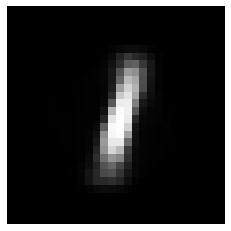

In [ ]:
digit_idx=1
for idx_rep in range(0, 10):
  z_0_digit = sample_digit(digit_idx, Y_test, 2**4, rotate=rotate_val)
  digit_img = digit_idx

  keep_rot_idx = Y_full_test[:,digit_img] > 0.9
  X_example = X_full_test[keep_rot_idx,]
  z_slack, mu_prop, z_rot = encoder.predict(X_example[0:batch_size,:], batch_size=batch_size)

  # slack, prop, rot
  slack_sample = [0,0,0,0,0,0,0,0,0,0]
  pred_input = np.concatenate([slack_sample, z_0_digit[0], rotate_1hot]).reshape((1,22))


  decoded = decoder.predict(pred_input)
  predictions = classification_model.predict(decoded)
  print(f" pred: {predictions}")

  print(f"rotated {digit_img}")
  plt.imshow(decoder.predict(pred_input).reshape(28,28), cmap = plt.cm.gray), axis('off')
  plt.show()

